In [15]:
from models.netvlad import NetVLAD

import torch
import torchvision.models as models

from PIL import Image
from torchvision import transforms

import os

from sklearn.metrics.pairwise import cosine_similarity

from matplotlib import pyplot as plt

import cv2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Matplotlib is building the font cache; this may take a moment.


In [4]:
# load pretrained model with netvlad
encoder = models.vgg16(pretrained=True).features[:-2]
encoder.outchannels = 512

net_vlad = NetVLAD(num_clusters=64, dim=512)
model = torch.nn.Sequential(encoder, net_vlad).to(device)

/Users/gau147/miniconda3/envs/py39/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/gau147/miniconda3/envs/py39/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /Users/gau147/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100.0%


In [ ]:
# preprocess the input image
trans = transforms.Compose([
    transforms.Resize((480, 640)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def extract_features(image_path):
    image = Image.open(image_path).convert('RGB')
    image = trans(image).unsqueeze(0).to(device)

    with torch.no_grad():
        descriptor = model(image)
        descriptor = descriptor / descriptor.norm(p=2) # normalize
        print("descriptor shape: ", descriptor.shape)
    
    return descriptor.squeeze().cpu()

In [6]:
# image database
src = './data/House_Room_Dataset/Bedroom'
images = sorted(os.listdir(src)[:300])
descriptors = torch.stack([extract_features(os.path.join(src, img)) for img in images])

descriptor shape:  torch.Size([1, 32768])
descriptor shape:  torch.Size([1, 32768])
descriptor shape:  torch.Size([1, 32768])
descriptor shape:  torch.Size([1, 32768])
descriptor shape:  torch.Size([1, 32768])
descriptor shape:  torch.Size([1, 32768])
descriptor shape:  torch.Size([1, 32768])
descriptor shape:  torch.Size([1, 32768])
descriptor shape:  torch.Size([1, 32768])
descriptor shape:  torch.Size([1, 32768])
descriptor shape:  torch.Size([1, 32768])
descriptor shape:  torch.Size([1, 32768])
descriptor shape:  torch.Size([1, 32768])
descriptor shape:  torch.Size([1, 32768])
descriptor shape:  torch.Size([1, 32768])
descriptor shape:  torch.Size([1, 32768])
descriptor shape:  torch.Size([1, 32768])
descriptor shape:  torch.Size([1, 32768])
descriptor shape:  torch.Size([1, 32768])
descriptor shape:  torch.Size([1, 32768])
descriptor shape:  torch.Size([1, 32768])
descriptor shape:  torch.Size([1, 32768])
descriptor shape:  torch.Size([1, 32768])
descriptor shape:  torch.Size([1, 

In [9]:
# Plotting function
def plot_images(input_image_path, result_image_paths, title):
    num_images = len(result_image_paths)
    num_cols = 5
    num_rows = (num_images + num_cols - 1) // num_cols + 1  # Adding one row for the input image
    plt.figure(figsize=(15, 3 * num_rows))
    
    # Plot the input image
    input_image = cv2.imread(input_image_path)
    input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
    plt.subplot(num_rows, num_cols, 1)
    plt.imshow(input_image)
    plt.title("Input Image")
    plt.axis('off')
    
    for i, image_path in enumerate(result_image_paths):
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        plt.subplot(num_rows, num_cols, i + 6)  # Start from the second subplot
        plt.imshow(image)
        plt.title(f'{os.path.basename(image_path)}')
        plt.axis('off')

    plt.suptitle(title)
    plt.show()

In [13]:
# query and retrieve similar images
input_image_path = './data/House_Room_Dataset/Bedroom/bed_1.jpg'
query_vec = extract_features(input_image_path).unsqueeze(0)

# compute similarity with database
similarities = cosine_similarity(query_vec, descriptors.numpy())
top_k_indices = similarities.argsort()[0][::-1][:5]  # top 5-k

descriptor shape:  torch.Size([1, 32768])


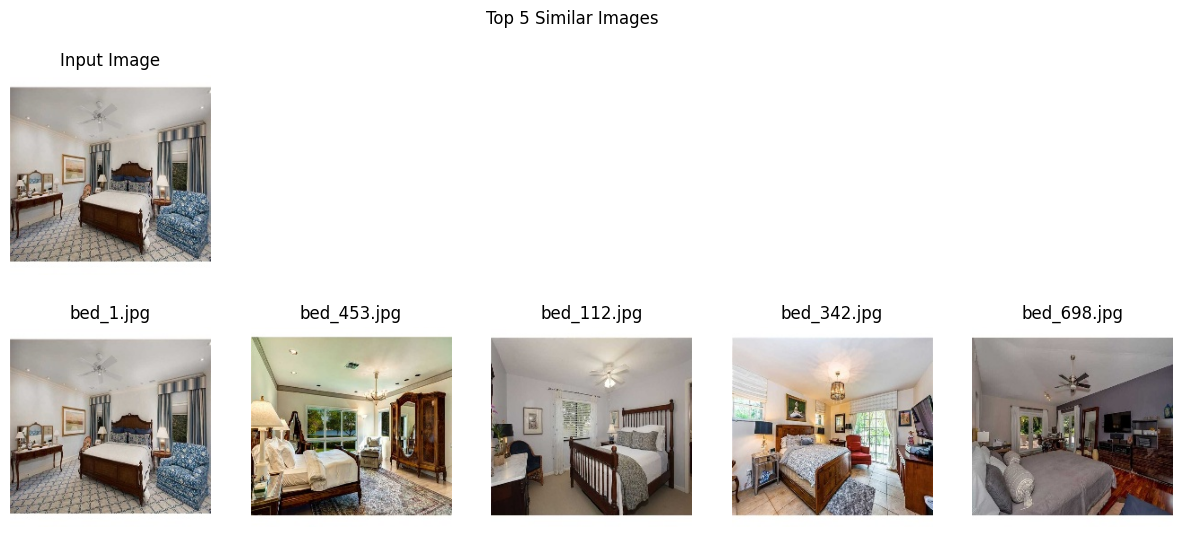

In [16]:
plot_images(input_image_path, [os.path.join(src, images[i]) for i in top_k_indices], "Top 5 Similar Images")

In [17]:
# Save to a file because it takes a while to compute
torch.save({
    'paths': images,
    'descriptors': descriptors.cpu()
}, 'netvlad_descriptors.pt')

In [18]:
# Code to load the saved descriptors
checkpoint = torch.load('netvlad_descriptors.pt')
image_paths = checkpoint['paths']              # List of image paths
descriptors = checkpoint['descriptors']

In [19]:
# test the saved descriptors
# query and retrieve similar images
input_image_path = './data/House_Room_Dataset/Bedroom/bed_2.jpg'
query_vec = extract_features(input_image_path).unsqueeze(0)

# compute similarity with database
similarities = cosine_similarity(query_vec, descriptors.numpy())
top_k_indices = similarities.argsort()[0][::-1][:5]  # top 5-k

TypeError: 'module' object is not callable